In [0]:
# Uncomment and Run the following lines of code to mount drive on to Colab

#from google.colab import drive
#drive.mount('/content/drive/')

In [15]:
# Change Runtime Type to GPU. The code below checks if the GPU is provisioned for this runtime
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, Model # Model is useful to edit the layers of an existing model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import warnings
warnings.filterwarnings('ignore', category = DeprecationWarning)

In [0]:
# Setting the dimensions of our images.

img_width, img_height = 224, 224

train_data_dir = '/content/drive/My Drive/DR_Kaggle/train' #copy path from the drive directory tree
validation_data_dir = '/content/drive/My Drive/DR_Kaggle/validation'

nb_train_samples = 413
nb_validation_samples = 103

epochs = 10   # we would be using 10 epochs. Try more epochs if the performance is good
batch_size = 20

In [0]:
# Setting the input shape format: 3 is the color channels (RGB)

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [19]:
# Loading the vgg16 model from keras with imagenet weights, setting the input shape to our interests 

vgg = keras.applications.vgg16.VGG16(include_top=True, weights='imagenet',
                               input_tensor=None, input_shape=input_shape, pooling=None)
vgg.summary()             # print out the model summary

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
# Freeze the layers so that they are not trained during model fitting. We want to keep the imagenet weights
for layer in vgg.layers: 
    layer.trainable=False

In [0]:
# Change the final dense layer to 1 node (sigmoid activation) for binary classification
# could do 2 nodes and determine the probabilities of each class using SoftMax, but we used Sigmoid for our simple ConvNet
x = vgg.layers[-2].output
output_layer = Dense(1, activation='sigmoid', name='predictions')(x)

In [0]:
# Combine the output layer to the original model
vgg_binary = Model(inputs=vgg.input, outputs=output_layer)

In [23]:
# Sanity check: Print out the model summary. The final layer should have 1 neuron only (again, using sigmoid activation)
vgg_binary.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
vgg_binary.compile(loss='binary_crossentropy', optimizer=sgd, metrics = ['accuracy'])

#vgg_binary.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
# Defining Image transformations: normalization (rescaling) for both training and testing images
# Defining Image transformations: Augmenting the training data with the following transformations 
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    #shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
# Setting up the flow of images in batches for training and validation
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Printing out the class labels for both training and validation sets
print(train_generator.class_indices)
print(validation_generator.class_indices)

Found 413 images belonging to 2 classes.
Found 103 images belonging to 2 classes.
{'Healthy': 0, 'Retinopathy': 1}
{'Healthy': 0, 'Retinopathy': 1}


In [27]:
# Fitting the modified vgg16 model on the image batches set up in the previous step
# Save the model (full model). Save the training history
history = vgg_binary.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,                           
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

# The following lines of code can be used to save the model with weights
#vgg_binary.save('vgg_binary.h5')
#print("Saved vgg16 model to disk") # the model size is over 500MB

Epoch 1/10
20/20 [==============================] - 125s 6s/step - loss: 0.6581 - accuracy: 0.6667 - val_loss: 0.6331 - val_accuracy: 0.6600
Epoch 2/10
20/20 [==============================] - 79s 4s/step - loss: 0.6364 - accuracy: 0.6336 - val_loss: 0.6691 - val_accuracy: 0.6506
Epoch 3/10
20/20 [==============================] - 69s 3s/step - loss: 0.6078 - accuracy: 0.6718 - val_loss: 0.6672 - val_accuracy: 0.6386
Epoch 4/10
20/20 [==============================] - 65s 3s/step - loss: 0.5674 - accuracy: 0.7150 - val_loss: 0.6394 - val_accuracy: 0.6988
Epoch 5/10
20/20 [==============================] - 64s 3s/step - loss: 0.5336 - accuracy: 0.7659 - val_loss: 0.5961 - val_accuracy: 0.6747
Epoch 6/10
20/20 [==============================] - 65s 3s/step - loss: 0.5603 - accuracy: 0.7150 - val_loss: 0.2903 - val_accuracy: 0.7108
Epoch 7/10
20/20 [==============================] - 69s 3s/step - loss: 0.5232 - accuracy: 0.7328 - val_loss: 0.6327 - val_accuracy: 0.6800
Epoch 8/10
20/20 [=

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


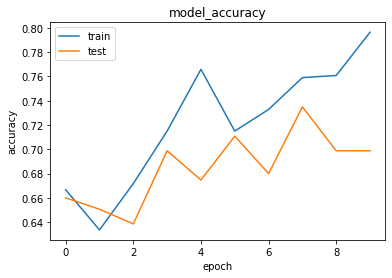

In [28]:
# Print out the metrics recorded during training (saved in the history)
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

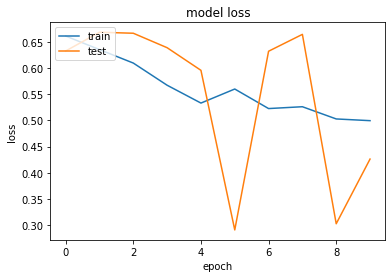

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()